In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.linear_model
import sklearn.neighbors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import warnings
warnings.filterwarnings("ignore")

import mlxtend.feature_selection
import mlxtend.preprocessing
import mlxtend.feature_extraction


In [3]:
data_full = pd.read_csv('full_data_short.csv')

#### Scale data and handle nan values MUST BE DONE BEFORE OTHER FUNCTIONS ON THIS NOTEBOOK

In [4]:
def handle_scale_and_nan(frame,nandecision='drop',scale='MinMax'):
    features = list(frame.select_dtypes(include='float64'))
    cat = list(frame.select_dtypes(include='object'))

    if scale == 'MinMax':
        scaler = sklearn.preprocessing.MinMaxScaler().fit(frame[features])
    elif scale == 'Standard':
        scaler = sklearn.preprocessing.StandardScaler().fit(frame[features])
        
    df_cont = pd.DataFrame(data=scaler.transform(frame[features]), columns=features)
    df_cat = pd.DataFrame(data=frame[cat], columns=cat)
    
    frame = pd.concat([df_cat,df_cont],axis=1)
    
    if nandecision == 'mean':
            for feature in features:
                frame[feature].fillna((frame[feature].mean()), inplace=True)
    elif nandecision == 'drop':
            frame = frame.dropna(axis=1)
        
    return frame

In [5]:
data_full = handle_scale_and_nan(data_full,nandecision='drop',scale='MinMax')

#### Pick random state for model selection such that the ratio of each category is approximately the same in all sets.
ie: healthy is 58% of training, dev, and test sets rather than 56%, 58%, and 61%. This function loops until the standard deviation between these percentages for each category is below some tolerance level. Based on the data we have, the random state 7975 produces standard deviations of the ratios less than 1%.

In [115]:
def split_cats_by_tolerance(frame,tolerance,
                       dev_test_split=0.15,train_val_split=0.15,
                       randstate=7975,step=1,
                       categories=['Healthy','AD_MCI','PD','PD_MCI_LBD'], retdev=False):
    """
    Split a chosen pandas dataframe into train, val, and test.
    df_full: the full dataframe
    tolerance: target standard deviation between category abundances in train, val, test frames.
                EG if category "a" has abundances of [0.554, 0.555, 0.571] in the train, val, and test frames, 
                    the std for "a" is 0.00779. 
                    If the stated tolerance is greater than 0.00779, category a is satisfied. 
                    All categories must be satisfied simultaneously by a single random state to break the loop.
    dev_test_split: first split between dev and test frames
    train_val_split: second split between train and val frames
    initial_random_state: start random state search here
    step: step of random state each loop
    categories: categories present in data
    retdev: if False (default), return = df_train, df_val, df_test
            if True, return = df_train, df_val, df_test, df_dev
    """
    
    import sklearn.model_selection
    import pandas as pd
    tolerable_list = []
    while sum(tolerable_list) != 4:
        df_dev, df_test = sklearn.model_selection.train_test_split(frame,test_size=dev_test_split,random_state=randstate)
        df_train, df_val = sklearn.model_selection.train_test_split(df_dev,test_size=train_val_split,random_state=randstate)
        
        train_dict = dict(df_train['group'].value_counts())
        val_dict = dict(df_val['group'].value_counts())
        test_dict = dict(df_test['group'].value_counts())

        tolerable_list = []
        stats_dict = {}
        for i in range(0,len(categories)):
            try:
                train_dict[categories[i]]
                val_dict[categories[i]]
                test_dict[categories[i]]
            except KeyError:
                break
            percents = [
                (train_dict[categories[i]]/len(df_train)),
                (val_dict[categories[i]]/len(df_val)),
                (test_dict[categories[i]]/len(df_test)),
                    ]
            standdev = np.std(percents)
            if standdev <= tolerance:
                tolerable_list.append(1)
                stats_dict[str(categories[i])] = [[*percents],standdev]
            else:
                tolerable_list.append(0) 
        randstate += step
    
#    if sum(tolerable_list) == 4:
#        print('Random state meeting tolerance threshold:',randstate-1)
#        print('Value counts in this state')
#        print(train_dict)
#        print(val_dict)
#        print(test_dict)
#        print()
#        for i in range(0,len(categories)):
#            print('\nPercent',categories[i],'in train, val, test:',stats_dict[categories[i]][0],
#                  '\nStandard deviation of these values:',stats_dict[categories[i]][1],'\n')
    
    if retdev == False:
        return df_train, df_val, df_test, randstate-1
    if retdev == True:
        return df_train, df_val, df_test, df_dev, randstate-1


In [117]:
data_train, data_val, data_test, randstate = split_cats_by_tolerance(data_full,tolerance=0.0096, randstate=90598)

In [118]:
randstate

90598

In [86]:
randstates = [4913,7975,9656,17540,19416,24399,26328,29070,32049,40571]

#### Reduce the number of samples of each category in the training data so they are equal

In [87]:
def train_cat_equalizer(df_train,randomstate=1,categories=['Healthy','AD_MCI','PD','PD_MCI_LBD']):
    """
    Randomly selects rows among each category such that each category has an equal number of rows.
    Ensures the truncated training frame has the same columns with NaN so if NaN columns are dropped, the truncated training frame has the same features as the val and test frames
    """
      
    # Determine the value counts of each category in in the training datal
    d = dict(df_train['group'].value_counts())
    min_cat = min(d, key=d.get)
    min_count = min(d.values())
    #print('Minimum category,',min_cat,', has',min_count,'rows... returning training data with',min_count,'rows for each category')
    
    # pd.sample will randomly sample rows. All chosen rows must have 
    
    dataframes = []
    for i in range(0,len(categories)):
        dataframes.append(df_train[df_train['group'] == categories[i]].sample(n=min_count,random_state=randomstate))
    trunc_df = pd.concat(dataframes)
    trunc_df = pd.DataFrame(trunc_df)

    return trunc_df

In [88]:
data_train_eq = train_cat_equalizer(data_train)
print('train (unequalized)\n',data_train['group'].value_counts())
print('\ntrain (equalized)\n',data_train_eq['group'].value_counts())
print('\nval\n',data_val['group'].value_counts())
print('\ntest\n',data_test['group'].value_counts())

train (unequalized)
 Healthy       112
AD_MCI         36
PD_MCI_LBD     27
PD             27
Name: group, dtype: int64

train (equalized)
 Healthy       27
AD_MCI        27
PD            27
PD_MCI_LBD    27
Name: group, dtype: int64

val
 Healthy       20
AD_MCI         7
PD_MCI_LBD     5
PD             4
Name: group, dtype: int64

test
 Healthy       24
AD_MCI         8
PD             5
PD_MCI_LBD     5
Name: group, dtype: int64


#### I noticed the model score varied greatly between runs of train_cat_equalizer. 
#### This would seem to indicate that some selections of 27 samples are better at training the classifier (at least against the validation data set)
#### one way to handle this is to loop through the data_train_eq and ridge classifier fit, thus resampling 27 samples over and over 

In [168]:
randystate = 32050
for loop in range(1,10):
    data_train, data_val, data_test, randomstate = split_cats_by_tolerance(data_full,tolerance=0.01, randstate=randystate)
    randomsamplestates = {}
    for i in range(1,50):
        data_train_eq = train_cat_equalizer(data_train,randomstate=i)
        X_train = data_train_eq.drop(columns=['group','assay_ID'])
        y_train = data_train_eq['group']
        X_val = data_val.drop(columns=['group','assay_ID'])
        y_val = data_val['group']
        model = sklearn.linear_model.RidgeClassifier()
        model.fit(X_train,y_train)
        randomsamplestates[i] = model.score(X_val,y_val)
    randommean = sum((randomsamplestates.values()))/len(randomsamplestates.values())
    meanie_01.append([randomstate,randommean])
    randystate = randomstate + 1
    loop += 1

In [158]:
meanie_01

[[4913, 0.6218820861678006],
 [7975, 0.7091836734693876],
 [9657, 0.536281179138322],
 [17540, 0.6405895691609976],
 [19416, 0.5413832199546486],
 [24399, 0.5640589569160995],
 [26328, 0.5997732426303856],
 [29070, 0.6394557823129253],
 [32049, 0.5861678004535149]]

In [174]:
meanie_01

[[4913, 0.6218820861678006],
 [7975, 0.7091836734693876],
 [9657, 0.536281179138322],
 [17540, 0.6405895691609976],
 [19416, 0.5413832199546486],
 [24399, 0.5640589569160995],
 [26328, 0.5997732426303856],
 [29070, 0.6394557823129253],
 [32049, 0.5861678004535149]]

In [173]:
meanie_0096

[[7975, 0.7091836734693876],
 [17540, 0.6405895691609976],
 [24399, 0.5640589569160995],
 [50276, 0.5238095238095238],
 [80942, 0.5708616780045352],
 [90598, 0.5986394557823131],
 [98281, 0.7006802721088433],
 [110681, 0.5804988662131519],
 [114014, 0.6054421768707483],
 [118763, 0.5470521541950113],
 [124982, 0.6417233560090703],
 [126705, 0.6547619047619047],
 [140876, 0.6230158730158731],
 [151236, 0.558390022675737]]

In [175]:
meanie0096 = []
for i in range(0,6):
    meanie0096.append(meanie_0096[i])

In [176]:
meanie0096

[[7975, 0.7091836734693876],
 [17540, 0.6405895691609976],
 [24399, 0.5640589569160995],
 [50276, 0.5238095238095238],
 [80942, 0.5708616780045352],
 [90598, 0.5986394557823131]]

In [108]:
randomsamplestates = {}
for i in range(1,10):
    data_train_eq = train_cat_equalizer(data_train,randomstate=i)
    X_train = data_train_eq.drop(columns=['group','assay_ID'])
    y_train = data_train_eq['group']
    X_val = data_val.drop(columns=['group','assay_ID'])
    y_val = data_val['group']
    model = sklearn.linear_model.RidgeClassifier()
    model.fit(X_train,y_train)
    randomsamplestates[i] = model.score(X_val,y_val)

In [110]:
    randommean = sum((randomsamplestates.values()))/len(randomsamplestates.values())


In [111]:
randommean

0.6040965207631878

In [109]:
for randomsamplestates in [randomstate_7975,randomstate_17540,randomstate_24399,randomstate_50276,randomstate_80942,randomstate_90598]:
    randommax = max(randomsamplestates.values())
    randommax_index = list(randomsamplestates.keys())[list(randomsamplestates.values()).index(randommax)]
    randommean = sum((randomsamplestates.values()))/len(randomsamplestates.values())
    randommin = min(randomsamplestates.values())
    randommin_index = list(randomsamplestates.keys())[list(randomsamplestates.values()).index(randommin)]

    #print('max score from random state screening:',randommax,
    #     '\n   max score index:',randommax_index)
    print('avg score from random state screening:',randommean)
    #print('min score from random state screening:',randommin,
    #     '\n   min score index:',randommin_index)

avg score from random state screening: 0.7084736251402912
avg score from random state screening: 0.6400112233445565
avg score from random state screening: 0.5594837261503933
avg score from random state screening: 0.5255331088664421
avg score from random state screening: 0.5575196408529743
avg score from random state screening: 0.6040965207631878


In [91]:
randomstate_7975 = randomsamplestates

<AxesSubplot: ylabel='Count'>

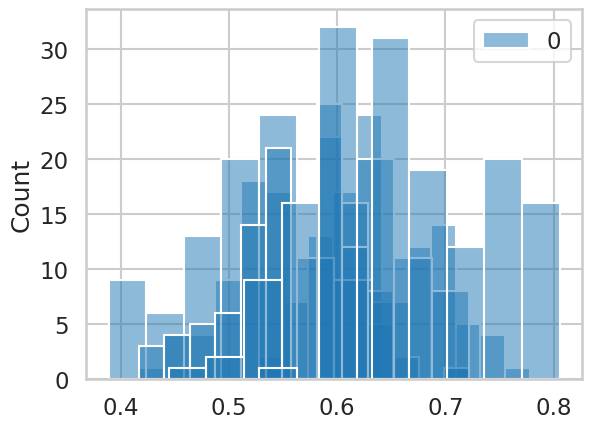

In [95]:
sns.histplot(randomstate_17540.values())
sns.histplot(randomstate_24399.values())
sns.histplot(randomstate_50276.values())
sns.histplot(randomstate_80942.values())
sns.histplot(randomstate_90598.values())
sns.histplot(randomstate_7975.values())


In [10]:
df_best_sample = data_train.sample(n=27, random_state=1285)
df_worst_sample = data_train.sample(n=27, random_state=1448)

In [12]:
X_test = data_test.drop(columns=['group','assay_ID'])
y_test = data_test['group']

In [13]:
data_train_eq = train_cat_equalizer(data_train,randomstate=199)
X_train = data_train_eq.drop(columns=['group','assay_ID'])
y_train = data_train_eq['group']
X_val = data_val.drop(columns=['group','assay_ID'])
y_val = data_val['group']
model = sklearn.linear_model.RidgeClassifier()
model.fit(X_train,y_train)
print('using a typical random state:')
print('val score:',model.score(X_val,y_val))
print('test score:',model.score(X_test,y_test))

data_train_eq = train_cat_equalizer(data_train,randomstate=1285)
X_train = data_train_eq.drop(columns=['group','assay_ID'])
y_train = data_train_eq['group']
X_val = data_val.drop(columns=['group','assay_ID'])
y_val = data_val['group']
model = sklearn.linear_model.RidgeClassifier()
model.fit(X_train,y_train)
print('\nusing the best random state:')
print('val score:',model.score(X_val,y_val))
print('test score:',model.score(X_test,y_test))

data_train_eq = train_cat_equalizer(data_train,randomstate=1448)
X_train = data_train_eq.drop(columns=['group','assay_ID'])
y_train = data_train_eq['group']
X_val = data_val.drop(columns=['group','assay_ID'])
y_val = data_val['group']
model = sklearn.linear_model.RidgeClassifier()
model.fit(X_train,y_train)
print('\nusing the worst random state:')
print('val score:',model.score(X_val,y_val))
print('test score:',model.score(X_test,y_test))

using a typical random state:
val score: 0.7222222222222222
test score: 0.6904761904761905

using the best random state:
val score: 0.9166666666666666
test score: 0.6190476190476191

using the worst random state:
val score: 0.5
test score: 0.6428571428571429


#### Moving forward with a randomstate giving near mean score: 199

In [14]:
data_train_eq = train_cat_equalizer(data_train,randomstate=199)
X_train = data_train_eq.drop(columns=['group','assay_ID'])
y_train = data_train_eq['group']

In [15]:
import sklearn.discriminant_analysis

In [16]:
def colorizer(group):
    if group == 'Healthy':
        return 'green'
    if group == 'AD_MCI':
        return 'blue'        
    if group == 'PD':
        return 'red'        
    if group == 'PD_MCI_LBD':
        return 'orange'

In [17]:
y_train_colors = list(map(colorizer,y_train))

3 component lda score: 0.6944444444444444


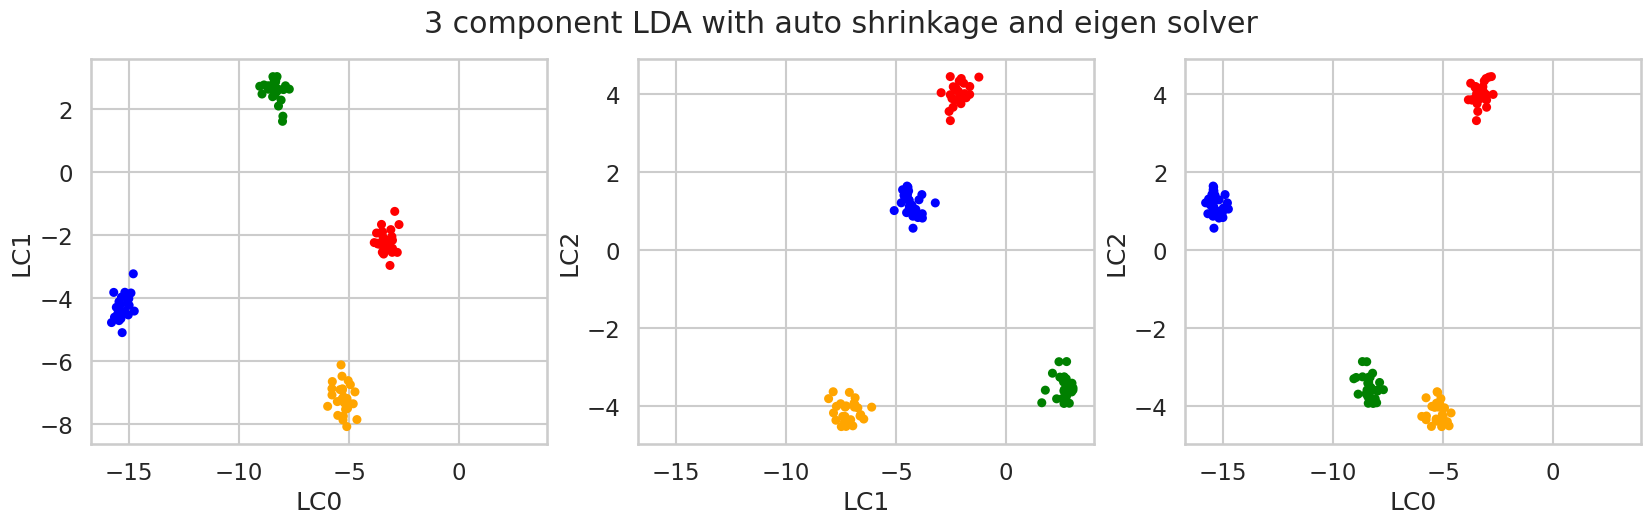

In [26]:
# LDA with 3 components
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=3,shrinkage='auto',solver='eigen')
X_lda = lda.fit_transform(X_train,y_train)
coef_df = pd.DataFrame(data=lda.coef_, columns=lda.feature_names_in_, index=['Healthy','AD_MCI','PD','PD_MCI_LBD'])

fig, axes = plt.subplots(1,3, figsize=(20,5), sharex=True)
fig.suptitle('3 component LDA with auto shrinkage and eigen solver')
axes[0].scatter(X_lda[:, 0], X_lda[:, 1], c=y_train_colors, s=25, cmap='plasma')
axes[0].set_xlabel('LC0')
axes[0].set_ylabel('LC1')

axes[1].scatter(X_lda[:, 1], X_lda[:, 2], c=y_train_colors, s=25, cmap='plasma')
axes[1].set_xlabel('LC1')
axes[1].set_ylabel('LC2')

axes[2].scatter(X_lda[:, 0], X_lda[:, 2], c=y_train_colors, s=25, cmap='plasma')
axes[2].set_xlabel('LC0')
axes[2].set_ylabel('LC2')

print('3 component lda score:',lda.score(X_val,y_val))

2 component lda score: 0.6944444444444444


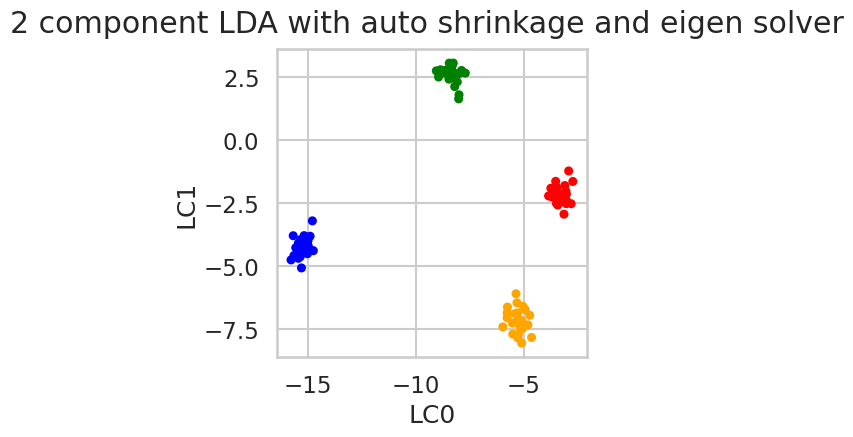

In [19]:
# LDA with 2 components
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=2,shrinkage='auto',solver='eigen')
X_lda = lda.fit_transform(X_train,y_train)
coef_df = pd.DataFrame(data=lda.coef_, columns=lda.feature_names_in_, index=['Healthy','AD_MCI','PD','PD_MCI_LBD'])

fig, ax = plt.subplots(figsize=(4,4), sharex=True)
fig.suptitle('2 component LDA with auto shrinkage and eigen solver')
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_train_colors, s=25, cmap='plasma')
ax.set_xlabel('LC0')
ax.set_ylabel('LC1')

print('2 component lda score:',lda.score(X_val,y_val))

In [30]:
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=2,shrinkage='auto',solver='eigen')

In [31]:
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=2, shrinkage='auto', solver='eigen')

In [32]:
lda.score(X_val,y_val)

0.6944444444444444

In [33]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()

In [34]:
qda.fit(X_train,y_train)

QuadraticDiscriminantAnalysis()

In [35]:
qda.score(X_val,y_val)

0.25

In [ ]:
import mrmr

In [100]:
linst = list(range(10,1100,10))

In [47]:
def mrmr_feature_selection(X_train, y_train,X_val,y_val,K,model):
    feature_performance = []
    for k in K:
        reduced_features = mrmr.mrmr_classif(X_train,y_train,K=k)
        X_train_reduced = X_train[reduced_features]
        X_val_reduced = X_val[reduced_features]
        model.fit(X_train_reduced,y_train)
        feature_performance.append([k,model.score(X_val_reduced,y_val),reduced_features])
    feature_performance.append([len(X_train.columns),model.score(X_val,y_val),X_train.columns])
    return feature_performance

In [103]:
feature_performance = mrmr_feature_selection(X_train,y_train,X_val,y_val,linst,sklearn.linear_model.RidgeClassifier())

100%|███████████████████████████████████████████████████████████████████████████████| 1090/1090 [00:56<00:00, 19.23it/s]


In [104]:
ks, scores, reduced_features = zip(*feature_performance)

In [67]:
ks, scores, reduced_features = zip(*feature_performance)

In [110]:
feature_performance_array = np.array(feature_performance)

In [117]:
np.save('feature_performance.npy',feature_performance_array)
 

In [113]:
feature_performance_df = pd.DataFrame(feature_performance_array)

In [115]:
feature_performance_df.to_('feature_performance.txt')


<AxesSubplot: >

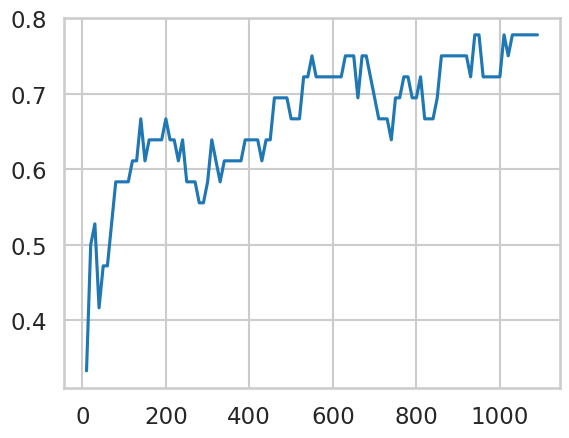

In [105]:
sns.lineplot(x=ks, y=scores)

TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e,%.18e,%.18e')

In [ ]:
X_train = data

In [85]:
kfold_cvd = {}
for i in range(0,len(reduced_features)):
    X = X_train[reduced_features[i]]
    y = y_train
    ridge = sklearn.linear_model.RidgeClassifier()
    kfold_cvd[ks[i]] = np.mean(cross_val_score(ridge, X, y))

Balanced score: evalutate score based on category one at a time
1. split dev data (?)
2. balance training data
3. feature select
4. evaluate... NOT ACCURACY
---repeat---
5. average 

take shared features

reduce features to 50, use xgboost, hyper parameter tuning function search, 


In [86]:


kfold_cvd

{100: 0.7134199134199134,
 200: 0.7229437229437229,
 300: 0.6484848484848486,
 400: 0.6203463203463203,
 500: 0.629004329004329,
 600: 0.6021645021645021,
 700: 0.6017316017316017,
 800: 0.6021645021645022,
 900: 0.5653679653679654,
 1000: 0.5281385281385281,
 1138: 0.5004329004329005}

In [87]:
kfold_cvd = []
for i in range(0,len(reduced_features)):
    X = X_train[reduced_features[i]]
    y = y_train
    ridge = sklearn.linear_model.RidgeClassifier()
    kfold_cvd.append([ks[i],np.mean(cross_val_score(ridge, X, y))])

In [88]:
kfold_cvd

[[100, 0.7134199134199134],
 [200, 0.7229437229437229],
 [300, 0.6484848484848486],
 [400, 0.6203463203463203],
 [500, 0.629004329004329],
 [600, 0.6021645021645021],
 [700, 0.6017316017316017],
 [800, 0.6021645021645022],
 [900, 0.5653679653679654],
 [1000, 0.5281385281385281],
 [1138, 0.5004329004329005]]

In [40]:
model.fit(X_train500,y_train)

RidgeClassifier()

In [41]:
model.score(X_val500,y_val)

0.6666666666666666